In [1]:
# Import python libraries

from tensorflow.keras.models import load_model

import h5py   # HDF5 data file management library
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Add, BatchNormalization, Concatenate, AveragePooling2D, Lambda, Multiply
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import callbacks
from tensorflow.keras.layers import LeakyReLU, ReLU
import tensorflow.keras.backend as K

from scipy.interpolate import interp1d


inc = 0

In [2]:
#data_psi = pd.read_csv("../input/cloakz/psi.csv",header=None)
data_para = pd.read_csv('../input/slits-data/Slits_para_w_phase.csv', header=None)
data_transr = pd.read_csv('../input/slits-data/Slits_trans_w_phaser.csv', header=None)
data_transi = pd.read_csv('../input/slits-data/Slits_trans_w_phasei.csv', header=None)


#data_para = pd.read_csv('drive/My Drive/Colab Notebooks/emb_rings_para.csv', header=None)
#data_refl = pd.read_csv('drive/My Drive/Colab Notebooks/emb_rings_refl.csv', header=None)

#data_Mat = pd.read_csv('drive/My Drive/Colab Notebooks/rand_poly/poly_Mat_0_1.csv', header=None)
#data_refl = pd.read_csv('drive/My Drive/Colab Notebooks/rand_poly/poly_refl_0_1.csv', header=None)

print(len(data_transr))

10266


In [3]:

data_transr = data_transr.T[0:data_transr.shape[1]-1];
data_transr = data_transr.T;

data_transi = data_transi.T[0:data_transi.shape[1]-1];
data_transi = data_transi.T;

data_para = data_para.T[0:data_para.shape[1]-1];
data_para = data_para.T;

data_transr = data_transr.values;
data_para = data_para.values;
data_transi = data_transi.values;

#data_refl = data_refl[:,::-1]


[0.2   0.048]


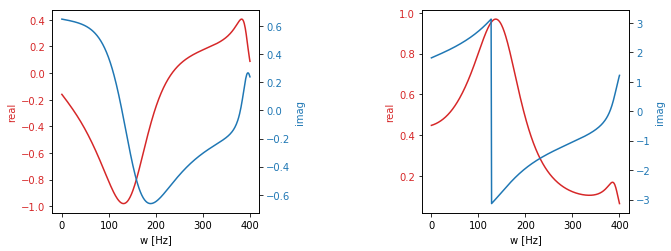

In [4]:
pos = 15;# lam = np.linspace(380,1200,501);

print(data_para[pos,:])

# Create some mock data

fig, ax1 = plt.subplots(1,2)

color = 'tab:red'
ax1[0].set_xlabel('w [Hz]')
ax1[0].set_ylabel('real', color=color)
ax1[0].plot(data_transr[pos,:], color=color);
ax1[0].tick_params(axis='y', labelcolor=color);

ax2 = ax1[0].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('imag', color=color)  # we already handled the x-label with ax1
ax2.plot(data_transi[pos,:], color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()

phase = np.arctan2(data_transi[pos,:],data_transr[pos,:])
trans = np.abs(data_transr[pos,:]+1j*data_transi[pos,:])**2



color = 'tab:red'
ax1[1].set_xlabel('w [Hz]')
ax1[1].set_ylabel('real', color=color)
ax1[1].plot(trans, color=color);
ax1[1].tick_params(axis='y', labelcolor=color);

ax4 = ax1[1].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax4.set_ylabel('imag', color=color)  # we already handled the x-label with ax1
ax4.plot(phase, color=color)
ax4.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_size_inches(10.5, 3.5)
plt.show()

In [5]:
#shuffling and dividing the data

indices = np.arange(data_transr.shape[0])
np.random.shuffle(indices)

data_transr =data_transr[indices]
data_para = data_para[indices]
data_transi = data_transi[indices]

data_t = np.concatenate([data_transr,data_transi],axis =1)
#data_t = data_transr;

#data_para_per = data_para_per.reshape(1,data_para_per.shape[0])

xtrain, xtest = np.split(
   data_para, 
    [ int(.8*len(data_para))
    ]
)

ytrain, ytest = np.split(
    data_t, 
    [int(.8*len(data_para))
    ]
)

In [6]:
lr = 0.0001
optimizer_type = Adam(lr=lr)  # optimisation algorithm: SGD stochastic gradient decent 
loss = 'mean_squared_error'# "categorical_crossentropy" #  # loss (cost) function to be minimised by the optimiser
metrics = ['mean_squared_error']  # network accuracy metric to be determined after each epoch
dropout_ratio = 0.05  # % of nodes in the hidden layer to dropout during back-propagation update of the network weights
validtrain_split_ratio = 0.2  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 225 # maxmimum number of epochs to be iterated
batch_size = 1  # batch size for the training data set
batch_shuffle = False   # shuffle the training data prior to batching before each epoch
initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)
regularizer = l1()
num_hidden = 251  # number of nodes in hidden fully connected layer

In [7]:
#@tf.function
def Lorentz(x):
  w = tf.linspace(1/(1.2),1/(0.4),data_transr.shape[1]);
  delta = tf.zeros([tf.shape(x)[0],w.shape[0]])
  w0 = tf.zeros([tf.shape(x)[0],1])
  g = tf.zeros([tf.shape(x)[0],1])
  c =  tf.zeros([tf.shape(x)[0],1])
  c_i = tf.zeros([tf.shape(x)[0],1])
  eq = tf.zeros([tf.shape(x)[0],w.shape[0]])
  
  w = tf.complex(w,0.0)
  #w2 = tf.ones([tf.shape(x)[0],w.shape[0]])
  #w2 = tf.complex(w2,0.0)
  #w2 = w2*w
  
  g = (x[:,0]);
  w0= (x[:,1]);
  c = (x[:,2]);
  c_i = (x[:,3]);
  
  delta = tf.complex(delta,0.0)
  w0 = tf.complex(w0,0.0)
  g = tf.complex(g,0.0)
  c = tf.complex(c,0.0)
  c_i = tf.complex(c_i,0.0)
  eq = tf.complex(0.0,0.0)
  
  w0 = tf.reshape(w0,[tf.shape(x)[0],1])
  g = tf.reshape(g,[tf.shape(x)[0],1])
  c = tf.reshape(c,[tf.shape(x)[0],1])
  c_i = tf.reshape(c,[tf.shape(x)[0],1])
  
  eq = (c*tf.exp(1j*c_i))/((w-w0)+1j*g);
  return eq



In [8]:

def block(input_tensor,num_hidden):
  #x = Dense(nb_nodes,kernel_initializer=initializer,bias_initializer = initializer,kernel_regularizer=regularizer)(input_tensor)
  x = Dense(num_hidden)(input_tensor)
  x = LeakyReLU()(x)
  #x = Dropout(dropout_ratio)(x)
  return x

def osc(input_tensor,num_hidden):
  block1 = block(input_tensor,num_hidden)
  #block2 = block(block1,num_hidden)
  block3 = block(block1,num_hidden)
  dense1a = Dense(2,activation='softplus')(block3)
  dense1b = Dense(2)(block3)
  dense1 = Concatenate()([dense1a,dense1b])
  outputs = Lambda(lambda x:Lorentz(x))(dense1)
  return outputs

def real_lay(x):
  x = (tf.math.real(x))
  return x

def imag_lay(x):
  x = (tf.math.imag(x))
  return x


def back(input_tensor,num_hidden):
  block1 = block(input_tensor,num_hidden)
  #block2 = block(block1,num_hidden)
  block3 = block(block1,num_hidden)
  dense1 = Dense(2)(block3)
  outputs = Lambda(lambda x:exp_back(x))(dense1)
  #c = tf.reshape(c,[tf.shape(x)[0],1])
  #a2 = tf.reshape(a2,[tf.shape(x)[0],1])
#  
  return back


def back_exp(x):
  #c = tf.ones([tf.shape(x)[0],data_transr.shape[1]])
  c = tf.complex(x,0.0)
  eq = tf.exp(1j*c)
  return eq


def back_cst(x):  #linear background
  a1 = tf.ones([tf.shape(x)[0],data_transr.shape[1]]);
  a1 = tf.complex(a1,0.0)
  c = tf.complex(x,0.0)
  c = tf.reshape(c,[tf.shape(x)[0],1])
  eq = a1*c;
  return eq


def back_lay_expc(input_tensor,num_hidden):
  block1 = block(input_tensor,num_hidden)
  #block2 = block(block1,num_hidden)
  block3 = block(block1,num_hidden)
  dense1 = Dense(data_transr.shape[1])(block3)
  dense2 = Dense(1)(block3)
  output1 = Lambda(lambda x:back_exp(x))(dense1)
  output2 = Lambda(lambda x:back_cst(x))(dense2)
  outputs = tf.math.multiply(output1,output2)
  return outputs

def back_lay_cst(input_tensor,num_hidden):
  block1 = block(input_tensor,num_hidden)
  #block2 = block(block1,num_hidden)
  block3 = block(block1,num_hidden)
  dense1 = Dense(1)(block3)
  outputs = Lambda(lambda x:back_cst(x))(dense1)
  return outputs


def schedule(epoch):
  return lr * (0.85 ** np.floor(epoch/10))


In [9]:
input_shape = (data_para.shape[1],)
inputs = Input(shape=input_shape)

osc1 = osc(inputs,num_hidden)
osc2 = osc(inputs,num_hidden)
osc3 = osc(inputs,num_hidden)
osc4 = osc(inputs,num_hidden)
osc5 = osc(inputs,num_hidden)
osc6 = osc(inputs,num_hidden)

back_l = back_lay_expc(inputs,num_hidden)

osc_eq = Add()([osc1,osc2,osc3,osc4,osc5,osc6])
osc_eq2 =tf.math.multiply(osc_eq,back_l)

outputs1 = real_lay(osc_eq2)
outputs2 = imag_lay(osc_eq2)

outputs = tf.concat([outputs1,outputs2],axis =1)


* Compiling the network model *

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 251)          753         input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 251)          753         input_1[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 251)          753         input_1[0][0]                    
____________________________________________________________

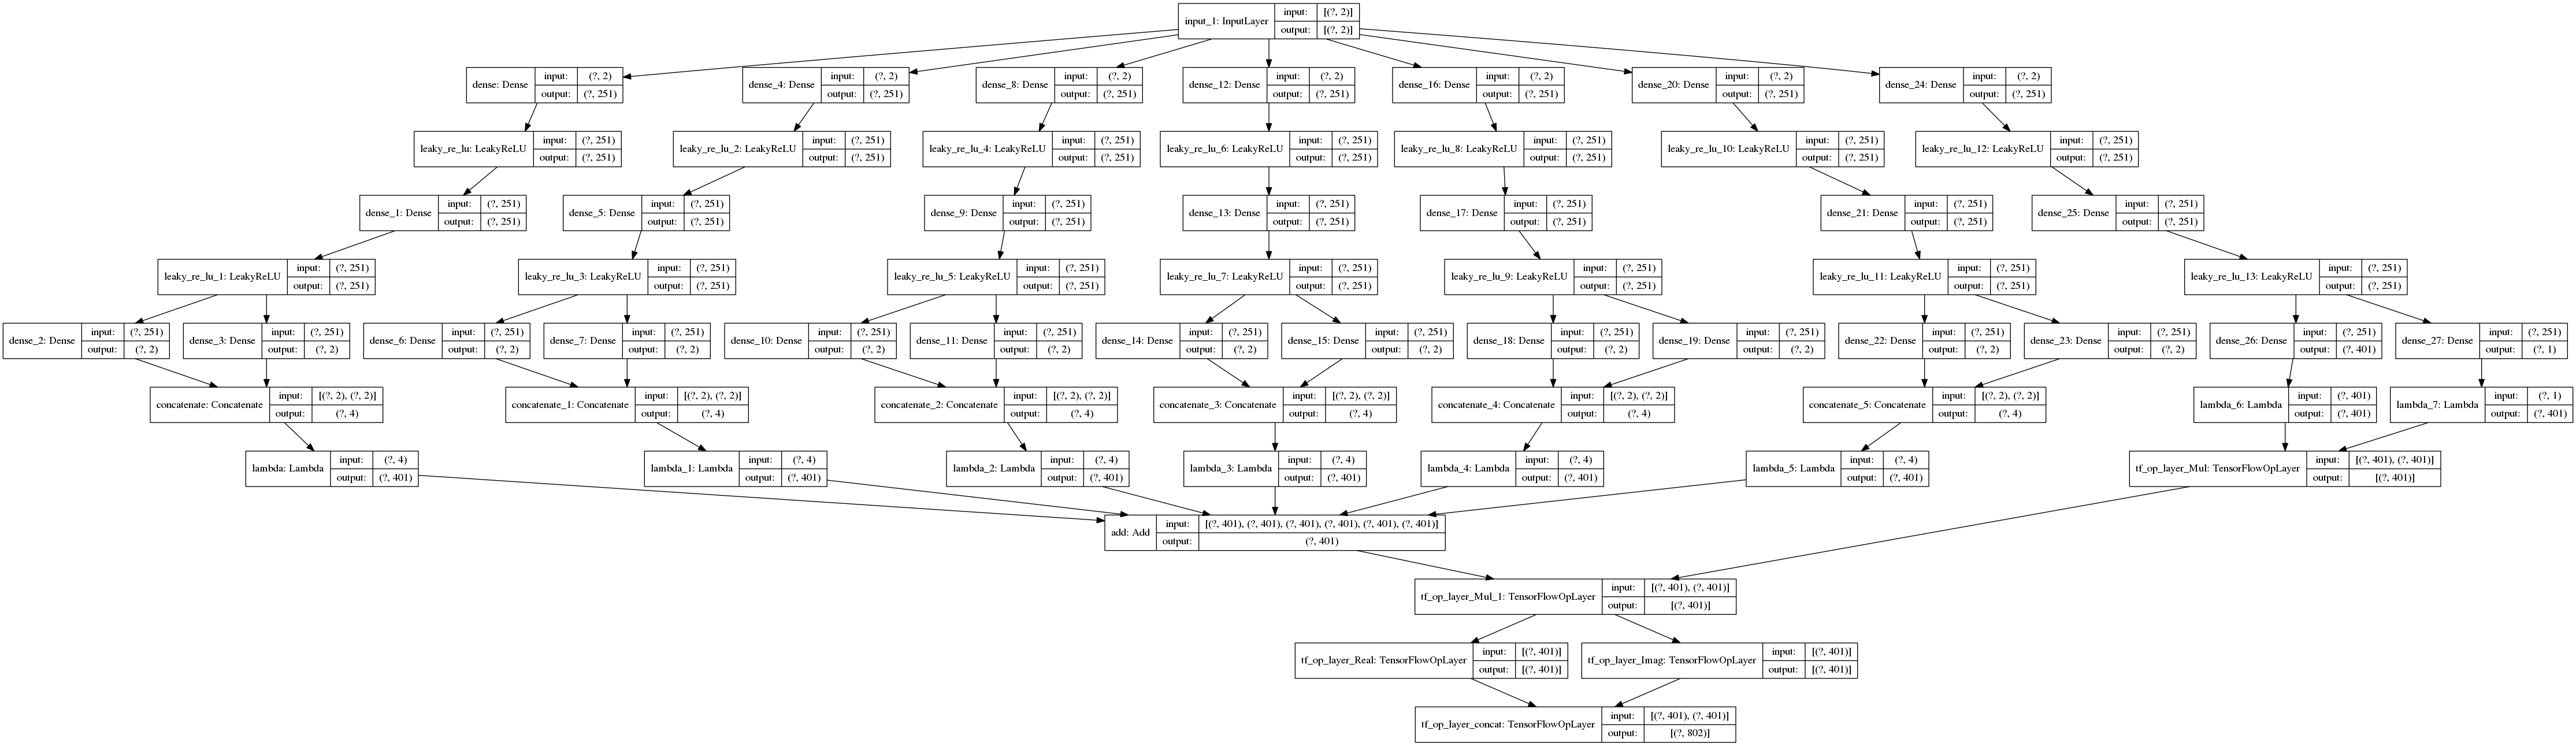

In [10]:
print()
print('* Compiling the network model *')
print()

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer_type, loss=loss, metrics=metrics)


# display a summary of the compiled neural network

print(model.summary())  
print()

# create and save a schematic image of the network architecture

from tensorflow.keras.utils import plot_model
from IPython.display import Image

print('Graphical schematic of the compiled network')
print()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(filename='model.png')

In [11]:
inc = inc+1;
#es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

es = callbacks.LearningRateScheduler(schedule, verbose=1)
es2 = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)


history = model.fit(xtrain,ytrain, validation_split=0.2,
          batch_size=batch_size,
          epochs=max_epochs,
          verbose=1,callbacks = [es,es2])

history_t = history


Train on 6569 samples, validate on 1643 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/225
6569/6569 [==============================] - 60s 9ms/sample - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0100 - val_mean_squared_error: 0.0100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 2/225
6569/6569 [==============================] - 55s 8ms/sample - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0027 - val_mean_squared_error: 0.0027

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 3/225
6569/6569 [==============================] - 57s 9ms/sample - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0020 - val_mean_squared_error: 0.0020

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 4/225
6569/6569 [==============================] - 56s 9ms/sample - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0014 - val_mean_squared_error: 0.0014


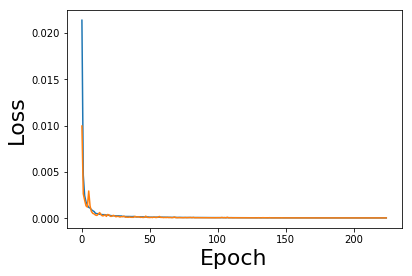

In [12]:
plt.plot(range(0,len(history.history['loss'])),history.history['loss'],range(0,len(history.history['loss'])),history.history['val_loss'])
plt.xlabel('Epoch',fontsize=22);plt.ylabel('Loss',fontsize=22);

In [13]:

slits_model = model.save('model_slits_lorentz.h5')
slits_model = model.save_weights('model_slits_lorentz_weights.h5')

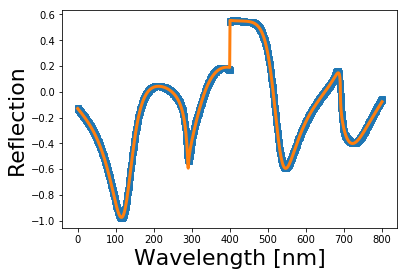

In [14]:
lam = np.linspace(1/1.2,1/0.4,401)

ans = model.predict(xtest)

pos = 26

#data_refl_test = pd.read_csv('drive/My Drive/Colab Notebooks/data_sets/Slits_refl_test.csv', header=None)
#data_refl_test = data_refl_test.T[0:201];
#data_refl_test = data_refl_test.T;
#data_refl_test = data_refl_test.values


plt.plot(ans[pos,:],'s')
plt.plot(ytest[pos,:],linewidth=3)


plt.xlabel('Wavelength [nm]',fontsize=22);plt.ylabel('Reflection',fontsize=22);

axes = plt.gca()
#axes.set_xlim([xmin,xmax])
#axes.set_ylim([0,1])

/opt/conda/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9998972389762265


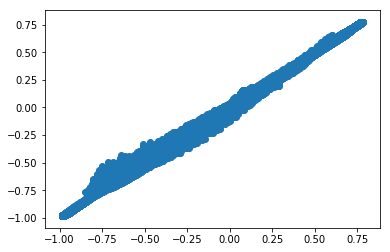

In [15]:
from scipy import stats

x=ytest
data_pred = model.predict([xtest])
y=data_pred

from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(x,y)
print(lm.score(x,y))
plt.scatter(x,y)

In [16]:
print('* Evaluating the performance of the trained network on the test dataset *')
print()

evaluate_model = model.evaluate(x=[xtest], y=ytest)
loss_metric = evaluate_model [0]
accuracy_metric = evaluate_model [1]

print()
print('Accuracy - ' + metrics[0] + ': %0.3f'%accuracy_metric)
print('Loss - ' + loss + ': %0.3f'%loss_metric)

* Evaluating the performance of the trained network on the test dataset *

2054/2054 [==============================] - 1s 560us/sample - loss: 6.2144e-05 - mean_squared_error: 6.2144e-05

Accuracy - mean_squared_error: 0.000
Loss - mean_squared_error: 0.000


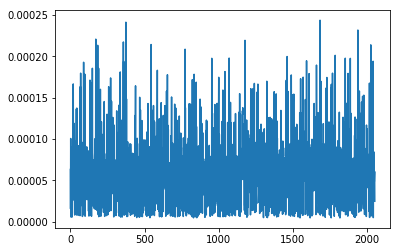

In [17]:
#%%script false

from scipy import stats

x=ytest
y = model.predict([xtest])

from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(x,y)
mse_box = []

for l in range(1,len(x)):
  mse_box.append(((x[l,:] - y[l,:])**2).mean())

plt.plot(mse_box)